In [283]:
import numpy as np
import pandas as pd
import seaborn as sb
import statsmodels
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

In [284]:
def load_data(filename,participant_id):
    df = pd.read_csv(direc + filename,header=None,names=['participant_id','i','ts','info'])
    events = [json.loads(e) for e in df[df['participant_id']==participant_id]['info']]
    return sorted(events,key=lambda e:e['event_time'])

def get_events_with_condition(f,condition):
    return [e for e in f if condition(e)]

def get_event_with_condition(f,condition):
    x = get_events_with_condition(f,condition)
    if len(x)==1:
        return x[0]
    else:
        return {}
    
def get_events_with_type(f,event_type):
    return get_events_with_condition(f,lambda e: e['event_type'].replace('_',' ')==event_type.replace('_',' '))

def get_event_with_type(f,event_type):
    return get_event_with_condition(f,lambda e: e['event_type'].replace('_',' ')==event_type.replace('_',' '))

#helper functions that encode boards as and moves as integers for the model fitting pipeline
def encode_board(pieces):
    return np.sum([2**i for i,p in enumerate(pieces) if p=='1']).astype(np.int64)

def encode_move(m):
    return 2**m

def get_parsed_data(data):
    your_turn_events = get_events_with_type(data,'your turn')
    user_move_events = get_events_with_type(data,'user move')
    assert(len(your_turn_events)==len(user_move_events))
    return [(e['event_info']['bp'],e['event_info']['wp'],e['event_info']['tile'],
             e['event_info']['user_color'],(e['event_time']-e_your_turn['event_time'])/1000)
            for e_your_turn,e in zip(your_turn_events,user_move_events)]

def check_event_counts(data,num_games):
    event_count_dict = defaultdict(lambda: 0, dict(zip(*np.unique([e['event_type'] for e in data],return_counts=True))))
    print(dict(event_count_dict))
    assert('start game' in event_count_dict)
    assert(event_count_dict['start game']==num_games)
    assert('end game' in event_count_dict and event_count_dict['end game']==num_games)
    assert(event_count_dict['user move']==event_count_dict['your turn'])
    assert(event_count_dict['opponent move']==event_count_dict['waiting for opponent'])
    assert(event_count_dict['opponent win'] + event_count_dict['user win'] + event_count_dict['draw'] == event_count_dict['start game'])

In [285]:
def display_board(bp,wp,move,color):
    fig = plt.figure()
    ax = fig.add_subplot(111,aspect='equal')
    rec = patches.Rectangle((-0.5,-0.5),9,4,color="gray",fill=True,zorder=1)
    ax.add_patch(rec)
    ax.vlines(np.arange(-0.5,9.5,1),-0.5,3.5)
    ax.hlines(np.arange(-0.5,4.5,1),-0.5,8.5)
    for i in range(36):
        if(bp[i]=='1'):
            circ = patches.Circle((i%9,3-i//9),0.33,color="black",fill=True)
            circ = ax.add_patch(circ)
        if(wp[i]=='1'):
            circ = patches.Circle((i%9,3-i//9),0.33,color="white",fill=True)
            circ = ax.add_patch(circ)
    circ = patches.Circle((move%9,3-move//9),0.33,color=color,fill=False)
    circ = ax.add_patch(circ)
    ax.axis('off')
    plt.show()

In [286]:
# directory where your data is stored
direc = '/Users/ilima/git/Four_in_a_row/Four_in_a_row_Analyses/Experiment code and data parse notebook/'
#name of the user whose data you want to analyze
#usernames = ['118:R_28AEWB4BHHAp3ic', '159:R_3kolXJjcfDsjL6k', '154:R_3kgZuiVj87g1GNO', '143:R_1PRYqkSFZQYTVUg', 
#            '160:R_3h5POosYswsLZqe', '153:R_reR4dauvBGinQvT', '131:R_3iJ8A5hXnygbqAF', '116:R_3qeT0l1LS4myHr4',
 #         '115:R_241tt6O6tVQs9NR', '128:R_AEYAh7gikx2YEvL', '106:R_1HqNZ7zU4Tb0SSR', '142:R_1InpeBO876j23Eh,
  #        '168:R_2ARs0RJIBjJZhYL']
#usernames = ['169:R_RQyaj0YbKu9fsDT', '141:R_1CK2JfPijAWf85C', '195:R_22tOmOP9V3YTA0u']
#usernames = ['A507:R_2b176cnRCyapnkx', 'A106:R_x6jDmbRb3oyYGdz', 'A108:R_2TnOx7dVPSonpTg', 'A116:R_cu9t4ZNp60qTplf',
#            'A120:R_PONVLZnwDK7wSpr', 'A123:R_2viEesh2c9XCBMe']
usernames = ['A112:R_1DSHShmupLFd4m9','A101:R_Q0Jd5lCBrQu5Dm9', 'A121:R_3j2tErwVrBPXWAH', 
             'A1083:R_0OFsszTuxG152et', 'A103:R_3lJsCIPqfpqRhkf', 'A130:R_zUdkqlxVsz3sXcJ',
            '101:R_31SM3mwQvAhBwar', '102:R_vdABJ1XvXNriwff', '107:R_2ahKzS67s2u094R',
            '117:R_2XpQzVOPaMJjkCo', '121:R_2zoxitKzRuYUblm', '129:R_2q8z9DfvMUHDZio',
            '139:R_1F5MGuZ2rKZOLnc', '152:R_XEQd4AtPvWuAWnT', '149:R_shhEOP9BPIFkz97', '150:R_3ilNhJufw9u0JJr',
            '156:R_2TTetTXWqRwQOGb', '166:R_9Nac2hjg6u7BlS1', '137:R_2X1ycnpBX7zJOwI',
            '256:R_10BfVTQovUcZioM', '175:R_2vjnTMhG0Bpa7wq', '181:R_3fDgQlApbcv1n4e',
            '187:R_3oHOHstFKN4HiLA', '192:R_1LeQOpZ9pat1k7D', '199:R_D1Afhly6eOCY66B',
             '201:R_3kzZPXnjFGbpt30', '202:R_2OHMsGSLXJZG0Bc', '200:R_1NCzjmN3Hl5r3HF',
             '194:R_24rdiskqYQc7BsO', '196:R_0voL9dLPRpILrS9', '197:R_bqny5leXGykyp0t',
             '179:R_2xV1IwgJyplwuvp', '180:R_1OGFPUUh0z8rWBh', '250:R_r2BwOdT2hnmQ5WN',
             '273:R_2zuodaGDxpO8dfe', '281:R_NVGtaI93MLLVQfT', '290:R_25zHKt5eqk2Fr1k',
             '305:R_WBOZ0yrZfLTCClz', '842:R_3jciZNiYxaSffqd',
             '846:R_z1hBUlYMwkfdbGh', '844:R_2D6PtBpvztH0yVh', '849:R_1im5d5ENT1vk0Xm',
             '856:R_3EEYoLyNN9SpuuT', '149:R_shhEOP9BPIFkz97', '150:R_3ilNhJufw9u0JJr',
             '156:R_2TTetTXWqRwQOGb', '166:R_9Nac2hjg6u7BlS1', '137:R_2X1ycnpBX7zJOwI'
             ]

#'841:R_25ZiTXX4Zh9Hnjz' completed 31 games but can later be included

#load other datafiles
age = pd.read_csv("demog_9dec.csv")
usernames_df = pd.DataFrame(usernames, columns=["Username"])
usernames_df['subject'] = usernames_df.index + 1
pars = pd.read_csv("paramsMatrix.csv", index_col=None)
pars = pd.merge(pars, usernames_df, on='subject', how='outer')
pars['StudyID'] = pars['Username'].str.split(':').str[0]
pars = pd.merge(age, pars, on='StudyID', how='outer')
pars = pars[pars['iteration'].notna()]
pars.tail()

,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,subject,iteration,pruningTheshold,StopProb,FeatureDropRate,LapseRate,ActiveScale,WeightCenter,TwoConnect,TwoUnconnect,ThreeConnect,FourConnect,Username
239,856,4/13/10,M,10.6493,10,12/3/20,43.0,1.0,0.92203,0.001060,0.158840,0.057451,0.80632,1.0619,0.85014,-0.99904,4.2745,9.9994,856:R_3EEYoLyNN9SpuuT
240,856,4/13/10,M,10.6493,10,12/3/20,43.0,2.0,1.20480,0.001021,0.004158,0.053442,0.84366,1.0338,0.56840,-0.45528,3.7111,9.9065,856:R_3EEYoLyNN9SpuuT
241,856,4/13/10,M,10.6493,10,12/3/20,43.0,3.0,1.93850,0.400940,0.097957,0.051701,0.86253,1.4758,0.91618,-0.28027,4.8649,9.9743,856:R_3EEYoLyNN9SpuuT
242,856,4/13/10,M,10.6493,10,12/3/20,43.0,4.0,1.20740,0.001000,0.007824,0.051007,0.84475,1.0008,0.55834,-0.33516,3.0504,9.8813,856:R_3EEYoLyNN9SpuuT
243,856,4/13/10,M,10.6493,10,12/3/20,43.0,5.0,1.14620,0.001510,0.004100,0.054648,0.71508,1.1438,0.44564,-0.67121,3.0986,9.8357,856:R_3EEYoLyNN9SpuuT


In [11]:
#name of your data file
filename = 'trialdata.csv'
data_dict = {username: load_data(filename,username) for username in usernames}
data = [data_dict[username] for username in usernames]
len(data)

48

In [291]:
# create reaction times csv
with open(direc + "reactiontimes.csv", "w") as outfile:
    outfile.write("User,GameNr,Category,Level,MoveNr,RT,Result\n")
    for username in usernames:
        # First go through all the events and record gane results
        game_results = {}
        for event in data_dict[username]:
            if event["event_type"] == "end game":
                # practice rounds will be overwritten because the "real" rounds have the same game_num
                game_results[event["event_info"]["game_num"]] = event["event_info"]["result"]
        is_practice = False
        # Go through all the events a second time and write csv lines as we go
        for event in data_dict[username]:
            if event["event_type"] == "start game":
                ei = event["event_info"]
                game_nr = ei["game_num"]
                move_nr = 0
                is_practice = ei["is_practice"]
                game_info = ",".join([str(x)for x in [game_nr, ei["category"], ei["level"]]])
            elif event["event_type"] == "your turn":
                prompt_time = int(event["event_time"])
            elif event["event_type"] == "user move":
                if is_practice:
                    continue
                move_time = int(event["event_time"])
                move_nr += 1
                line = ",".join([username, game_info, str(move_nr), str((move_time - prompt_time) / 1000), game_results[game_nr]])
                outfile.write(line + "\n")

In [10]:
#the second argument in check_data is the number of games that ought to exist for this user
#if this function failes an assertion, something is wrong with your data, including practise trials
#this function will print the count of all the event type in the data
for index in range(len(data)):
    d = data[index]
    print(usernames[index])
    check_event_counts(d,37)
    for event in d:
        if event['event_type'] == 'adjust level':
            print(event)
    for bp,wp,m,c,rt in get_parsed_data(d):
        assert(len(bp.split('1'))-len(bp.split('1')) in [0,1])
    

A112:R_1DSHShmupLFd4m9
{'adjust level': 37, 'end game': 37, 'opponent move': 232, 'opponent win': 8, 'quiz answer': 5, 'show instructions': 16, 'start game': 37, 'user move': 243, 'user win': 29, 'waiting for opponent': 232, 'your turn': 243}
{'event_type': 'adjust level', 'event_info': {'category': 2, 'maxCategory': 20}, 'event_time': 1604012248421}
{'event_type': 'adjust level', 'event_info': {'category': 3, 'maxCategory': 20}, 'event_time': 1604012299204}
{'event_type': 'adjust level', 'event_info': {'category': 3, 'maxCategory': 20}, 'event_time': 1604012371115}
{'event_type': 'adjust level', 'event_info': {'category': 4, 'maxCategory': 20}, 'event_time': 1604012386501}
{'event_type': 'adjust level', 'event_info': {'category': 5, 'maxCategory': 20}, 'event_time': 1604012426077}
{'event_type': 'adjust level', 'event_info': {'category': 6, 'maxCategory': 20}, 'event_time': 1604012461789}
{'event_type': 'adjust level', 'event_info': {'category': 7, 'maxCategory': 20}, 'event_time': 16

AssertionError: 

In [292]:
def categoryHist(username, data):
    table = np.empty([0,6])
    category = 2
    for event in data:
        if event['event_type'] == 'user move':
            color = event['event_info']['user_color']
        if event['event_type'] == 'adjust level':
            category = event['event_info']['category']
        if event['event_type'] == 'end game':
            result = event['event_info']['result']
            resultCode = 1 if result == 'win' else -1 if result == 'opponent win' else 0
            table = np.vstack((table, [username, event['event_info']['game_num'], int(category), event['event_info']['level'], color, resultCode]))
    return table


In [293]:
#create dataframe
dataframeData = np.empty([0,6]) 
for index in range(len(data)):
    d = data[index]
    dataframeData = np.vstack((dataframeData, categoryHist(usernames[index], d)))
dataFrame = pd.DataFrame(data = dataframeData, columns = ['subject', 'gameNumber', 'category', 'level', 'user_color', 'outcome'])

dataFrame
dataFrame.to_csv(r'/Users/ilima/Google Drive/Projects/Cate Hartley Weiji/4inarow_fitting_results/forElo.csv', index = False) 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

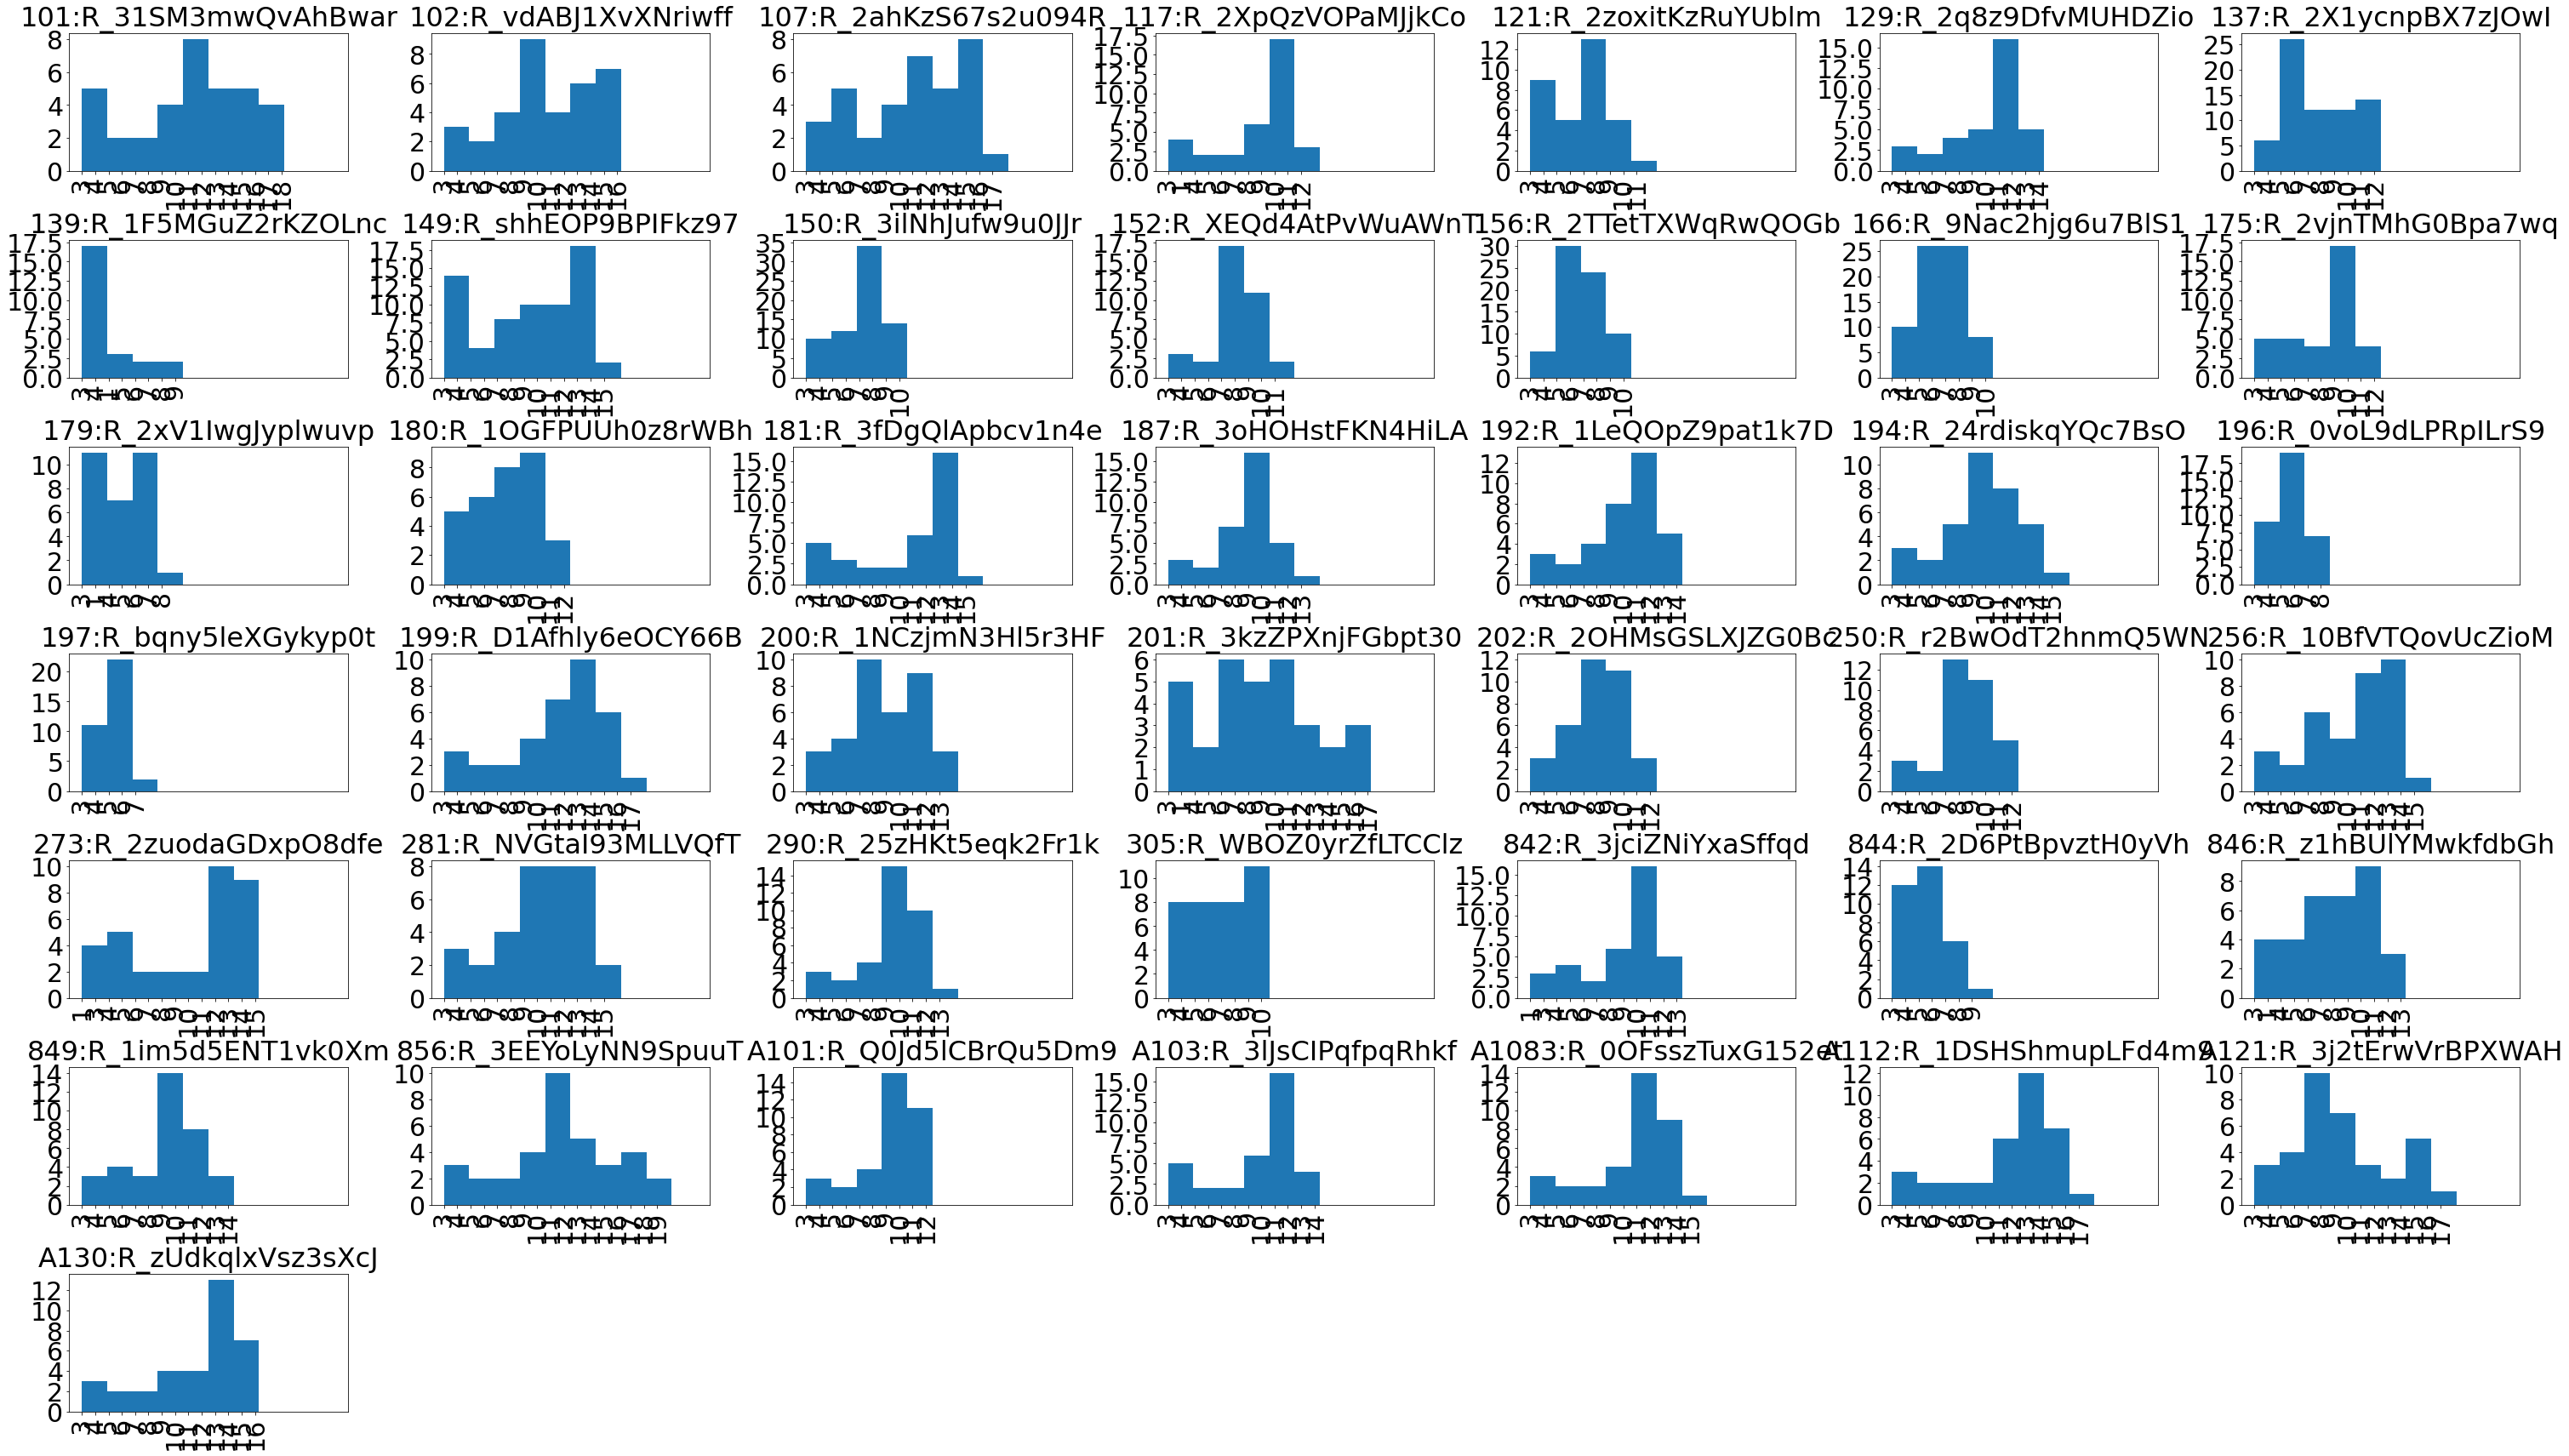

In [294]:
hists = dataFrame['category'].hist(by=dataFrame['subject'], range=[1,20], figsize=(50, 30), xlabelsize=30, ylabelsize=30)
[x.title.set_size(32) for x in hists.ravel()]


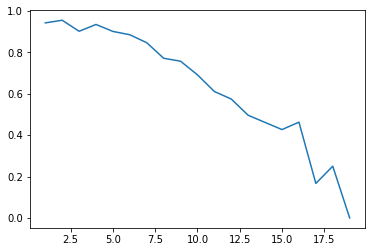

In [295]:
plt.figure()
dataFrame['count'] = 1
dataFrame['win'] = (dataFrame['outcome'] == '1').astype(int)
dataFrame['category'] = pd.to_numeric(dataFrame['category'])
dataWinCount = dataFrame.groupby(['subject', 'category'], as_index=False).sum()
dataWinCount['winRate'] = dataWinCount['win']/dataWinCount['count']
dataWinCount = dataWinCount.groupby(['category'], as_index=False).mean()

plt.plot(dataWinCount['category'],dataWinCount['winRate'] )

Text(0.5, 0, 'Category')

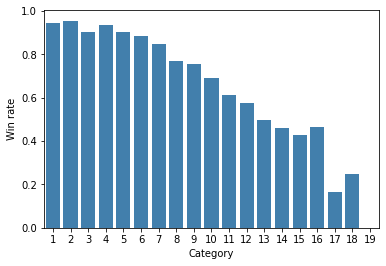

In [296]:
ax = sb.barplot(x="category", y="winRate", data=dataWinCount, ci = None, color = "#3182bd")
plt.ylabel("Win rate")
plt.xlabel("Category")

In [297]:
dataWinCount.head()

,category,count,win,winRate
0,1,2.285714,2.000000,0.942857
1,2,3.000000,2.837209,0.955652
2,3,3.232558,2.744186,0.902296
3,4,2.069767,1.767442,0.935216
4,5,2.860465,2.372093,0.901583


In [298]:
dataFrame['subjectNr'] = dataFrame['subject'].str.split(':').str[0]
age['subjectNr'] = age['StudyID']
df_age_cat = pd.merge(age, dataFrame, on='subjectNr', how='outer')
df_age_cat = df_age_cat[df_age_cat['gameNumber'].notna()]
df_age_winrate = df_age_cat.groupby(['subjectNr'], as_index=False).mean()
df_age_medcat = df_age_cat.groupby(['subjectNr'], as_index=False).median()
df_age_maxcat = df_age_cat.groupby(['subjectNr'], as_index=False).max()
df_age_cat.tail()

,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,subjectNr,subject,gameNumber,category,level,user_color,outcome,count,win
1773,856,4/13/10,M,10.6493,10,12/3/20,856,856:R_3EEYoLyNN9SpuuT,30,19.0,184,black,0,1.0,0.0
1774,856,4/13/10,M,10.6493,10,12/3/20,856,856:R_3EEYoLyNN9SpuuT,31,19.0,181,white,-1,1.0,0.0
1775,856,4/13/10,M,10.6493,10,12/3/20,856,856:R_3EEYoLyNN9SpuuT,32,18.0,170,black,-1,1.0,0.0
1776,856,4/13/10,M,10.6493,10,12/3/20,856,856:R_3EEYoLyNN9SpuuT,33,17.0,166,white,-1,1.0,0.0
1777,856,4/13/10,M,10.6493,10,12/3/20,856,856:R_3EEYoLyNN9SpuuT,34,16.0,150,black,1,1.0,1.0


Text(0.5, 0, 'Subject')

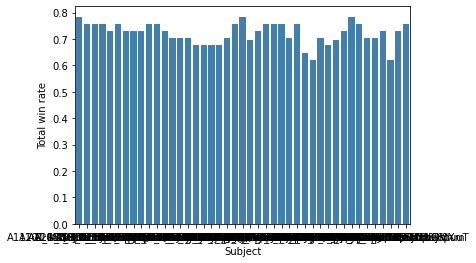

In [299]:
ax = sb.barplot(x="subject", y="win", data=dataFrame, ci = None, color = "#3182bd")
plt.ylabel("Total win rate")
plt.xlabel("Subject")


,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,subjectNr,subject,gameNumber,category,level,user_color,outcome,count,win,ageBins
0,A101,9/26/99,F,21.1151,21,11/1/20,A101,A101:R_Q0Jd5lCBrQu5Dm9,0,2.0,1,black,1,1.0,1.0,"(18, 26]"
30,A101,9/26/99,F,21.1151,21,11/1/20,A101,A101:R_Q0Jd5lCBrQu5Dm9,28,11.0,107,black,1,1.0,1.0,"(18, 26]"
60,A103,8/11/00,F,20.2438,20,11/3/20,A103,A103:R_3lJsCIPqfpqRhkf,21,12.0,115,white,1,1.0,1.0,"(18, 26]"
90,A112,2/24/01,F,19.6904,19,10/29/20,A112,A112:R_1DSHShmupLFd4m9,14,12.0,112,black,1,1.0,1.0,"(18, 26]"
120,A121,2/10/01,F,19.7370,19,11/1/20,A121,A121:R_3j2tErwVrBPXWAH,7,9.0,82,white,-1,1.0,0.0,"(18, 26]"
150,A1083,10/16/97,M,23.0630,23,11/2/20,A1083,A1083:R_0OFsszTuxG152et,0,3.0,14,black,1,1.0,1.0,"(18, 26]"
180,A1083,10/16/97,M,23.0630,23,11/2/20,A1083,A1083:R_0OFsszTuxG152et,30,15.0,146,black,-1,1.0,0.0,"(18, 26]"
210,A130,10/22/98,M,22.0493,22,11/3/20,A130,A130:R_zUdkqlxVsz3sXcJ,22,14.0,137,black,-1,1.0,0.0,"(18, 26]"
240,101,5/19/03,F,17.4904,17,11/9/20,101,101:R_31SM3mwQvAhBwar,15,11.0,101,white,1,1.0,1.0,"(12, 18]"
270,102,11/12/05,F,15.0055,15,11/10/20,102,102:R_vdABJ1XvXNriwff,8,10.0,98,black,1,1.0,1.0,"(12, 18]"


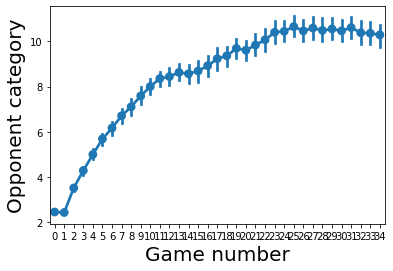

In [334]:
win_age = sb.pointplot(x="gameNumber", y="category", data=df_age_cat, ci =68)
plt.ylabel("Opponent category", fontsize=20)
plt.xlabel("Game number", fontsize=20)
bins = [7, 12, 18, 26]
df_age_cat['ageBins'] = pd.cut(df_age_cat['FlooredAge'], bins)
df_age_cat.loc[[x * 30 for x in range(20)],:]

Text(0.5, 0, 'Game number')

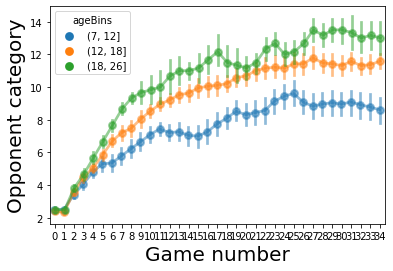

In [335]:
df_age_cat2 = df_age_cat
df_age_cat2["gameNumber"] = pd.to_numeric(df_age_cat2["gameNumber"])
win_age = sb.pointplot(x="gameNumber", y="category", data=df_age_cat2, ci =68, hue = "ageBins", dodge=True,plot_kws=dict(alpha=0.3))
plt.setp(win_age.collections, alpha=.5) #for the markers
plt.setp(win_age.lines, alpha=.5) 
plt.ylabel("Opponent category", fontsize=20)
plt.xlabel("Game number", fontsize=20)

Text(0.5, 0, 'Age')

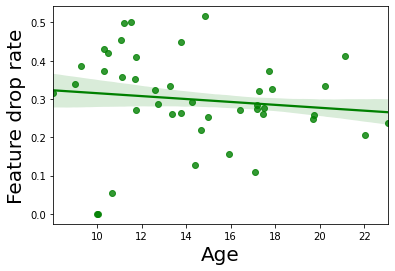

In [253]:
pars_mean = pars.groupby(['StudyID'], as_index=False).mean()
win_age = sb.regplot(x="ExactAge", y="FeatureDropRate", data=pars_mean, ci =68, color = "green")
plt.ylabel("Feature drop rate", fontsize=20)
plt.xlabel("Age", fontsize=20)


Text(0.5, 0, 'Age')

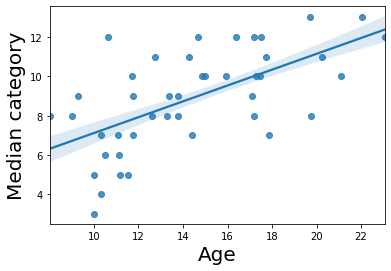

In [160]:
win_age = sb.regplot(x="ExactAge", y="category", data=df_age_medcat, ci =68)
plt.ylabel("Median category", fontsize=20)
plt.xlabel("Age", fontsize=20)


Text(0.5, 0, 'Age')

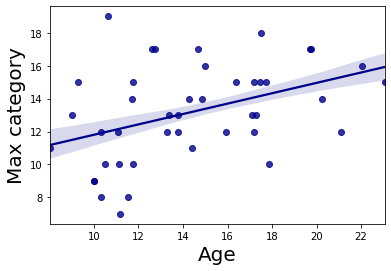

In [158]:
win_age = sb.regplot(x="ExactAge", y="category", data=df_age_maxcat, ci = 68, color = "Darkblue")
plt.ylabel("Max category", fontsize=20)
plt.xlabel("Age", fontsize=20)

Text(0.5, 0, 'Age')

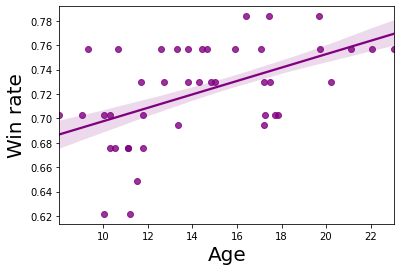

In [159]:
win_age = sb.regplot(x="ExactAge", y="win", data=df_age_winrate, ci=68, color = 'Purple')
plt.ylabel("Win rate", fontsize=20)
plt.xlabel("Age", fontsize=20)

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
Name: category, dtype: int64
    category     count       win   winRate
0          1  2.285714  2.000000  0.942857
1          2  3.000000  2.837209  0.955652
2          3  3.232558  2.744186  0.902296
3          4  2.069767  1.767442  0.935216
4          5  2.860465  2.372093  0.901583
5          6  3.348837  2.488372  0.885465
6          7  3.627907  2.697674  0.847093
7          8  3.619048  2.547619  0.771863
8          9  4.050000  2.775000  0.757589
9         10  4.184211  2.868421  0.691667
10        11  4.029412  2.470588  0.611111
11        12  4.031250  2.593750  0.574678
12        13  3.920000  2.280000  0.496095
13        14  3.150000  1.600000  0.461548
14        15  2.500000  1.250000  0.427083
15        16  2.555556  1.222222  0.462963
16        17  1.428571  0.428571  0.166667
17        18  1.500000  0.

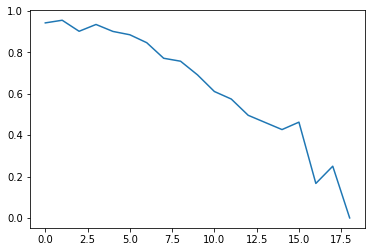

In [56]:
#plot winrate as function of category
dataFrame['count'] = 1
dataFrame['win'] = (dataFrame['outcome'] == '1').astype(int)
dataFrame['category'] = pd.to_numeric(dataFrame['category'])
dataWinCount = dataFrame.groupby(['subject', 'category'], as_index=False).sum()
dataWinCount['winRate'] = dataWinCount['win']/dataWinCount['count']
dataWinCount = dataWinCount.groupby(['category'], as_index=False).mean()
print(dataWinCount['category'])
print(dataWinCount)
dataWinCount['winRate'].plot.line()

In [57]:
len(data)

48

In [58]:
def save_data(data):
    if not os.path.exists(direc + 'raw/'):
        os.mkdir(direc + 'raw/')
    if not os.path.exists(direc + 'splits/'):
        os.mkdir(direc + 'splits/')
    for i,(d,username) in enumerate(zip(data,usernames)):
        print(f"{i}: {username} {len(d)}")
        parsed_data = get_parsed_data(d)
        with open(direc + 'raw/' + username.split(':')[0] + '.csv','w') as f:
            df = pd.DataFrame([(encode_board(bp),encode_board(wp),c.lower().capitalize(),encode_move(m),rt,username.split(':')[0]) for bp,wp,m,c,rt in parsed_data])
            f.write(df.to_csv(None, index = False, header=False,sep='\t',line_terminator ='\n')[:-1])
        group = (5*(np.random.permutation(len(parsed_data))/len(parsed_data))).astype(int)+1
        if not os.path.exists(direc + 'splits/' + str(i+1)):
            os.mkdir(direc + 'splits/' + str(i+1))
        with open(direc + 'splits/' + str(i+1) + '/data.csv','w') as f:
            df = pd.DataFrame([(encode_board(bp),encode_board(wp),c.lower().capitalize(),encode_move(m),rt,g,username.split(':')[0]) for (bp,wp,m,c,rt),g in zip(parsed_data,group)])
            f.write(df.to_csv(None, index = False, header=False,sep='\t',line_terminator ='\n')[:-1])
        for g in range(1,6):
            with open(direc + 'splits/' + str(i+1) + '/' + str(g) + '.csv','w') as f:
                df = pd.DataFrame([(encode_board(bp),encode_board(wp),c.lower().capitalize(),encode_move(m),rt,g,username.split(':')[0]) for (bp,wp,m,c,rt),g in zip(parsed_data,group)])
                f.write(df[df[5]==g].to_csv(None, index = False, header=False,sep='\t',line_terminator ='\n')[:-1])


In [59]:
save_data(data)

0: A112:R_1DSHShmupLFd4m9 1119
1: A101:R_Q0Jd5lCBrQu5Dm9 1029
2: A121:R_3j2tErwVrBPXWAH 1025
3: A1083:R_0OFsszTuxG152et 1085
4: A103:R_3lJsCIPqfpqRhkf 1133
5: A130:R_zUdkqlxVsz3sXcJ 1093
6: 101:R_31SM3mwQvAhBwar 1283
7: 102:R_vdABJ1XvXNriwff 1141
8: 107:R_2ahKzS67s2u094R 943
9: 117:R_2XpQzVOPaMJjkCo 941
10: 121:R_2zoxitKzRuYUblm 1101
11: 129:R_2q8z9DfvMUHDZio 1091
12: 139:R_1F5MGuZ2rKZOLnc 1649
13: 152:R_XEQd4AtPvWuAWnT 1027
14: 149:R_shhEOP9BPIFkz97 1105
15: 150:R_3ilNhJufw9u0JJr 1187
16: 156:R_2TTetTXWqRwQOGb 1025
17: 166:R_9Nac2hjg6u7BlS1 1223
18: 137:R_2X1ycnpBX7zJOwI 1295
19: 256:R_10BfVTQovUcZioM 1211
20: 175:R_2vjnTMhG0Bpa7wq 1035
21: 181:R_3fDgQlApbcv1n4e 935
22: 187:R_3oHOHstFKN4HiLA 913
23: 192:R_1LeQOpZ9pat1k7D 1123
24: 199:R_D1Afhly6eOCY66B 1141
25: 201:R_3kzZPXnjFGbpt30 1157
26: 202:R_2OHMsGSLXJZG0Bc 973
27: 200:R_1NCzjmN3Hl5r3HF 1113
28: 194:R_24rdiskqYQc7BsO 861
29: 196:R_0voL9dLPRpILrS9 1325
30: 197:R_bqny5leXGykyp0t 1521
31: 179:R_2xV1IwgJyplwuvp 1137
32: 180:R_1OGFPUU

In [ ]:
[len(get_parsed_data(d)) for d in data]

In [167]:
#print gameplay on boards - adjust for selected subject
#for d in data[12:13]:
#    for bp,wp,m,c,rt in get_parsed_data(d)[-35:]:
#        print(bp,wp,m,c,rt)
#        display_board(bp,wp,m,c)

In [170]:
inputDir = '/Users/ilima/Google Drive/Projects/Cate Hartley Weiji/4inarow_fitting_results'
with open(inputDir + '/paramsMatrix.csv', 'w') as outfile:
    for subject in range(48):
        for paramnr in range(5):
            outfile.write(str(subject+1)+','+str(paramnr+1) + ',')
            with open(inputDir + '/' + str(subject + 1) + '/' + 'params' + str(paramnr+1) + '.csv')as infile:
                line = infile.readline()
                outfile.write(line)

